In [59]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [62]:
from koopmanlib.functions import *

In [63]:
import json
import sys

# Generate data

In [64]:
config_file = "config_fhn.json"

In [65]:
with open(config_file, "r") as f:
    config = json.load(f)["fhn_high_dim_u_settings"]

In [66]:
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]


In [67]:
Nx = config["data_settings"]["Nx"]
n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

In [68]:
n_psi_train = config["nn_settings"]["n_psi_train"]
target_dim = Nx * 2
param_dim = 3
n_psi = 1 + target_dim + n_psi_train
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

In [69]:
K_layer_size

[64]

In [70]:
x = np.linspace(-10, 10, Nx)
t = np.arange(0, traj_len, 1)

In [71]:
from koopmanlib.target import ModifiedFHNTarget

In [72]:
fhn_pde = ModifiedFHNTarget(
    x=x, dt=1e-5, t_step=1e-3, dim=target_dim, param_dim=param_dim, param_input=1e3
)

In [73]:
data_dict = np.load(
    os.path.join(data_path, "data_high_u_fhn_Nx_" + str(Nx) + ".npy"), allow_pickle=True
)

In [74]:
data_z_curr = data_dict[()]["data_z_curr"]
data_u = data_dict[()]["data_u"]
data_z_next = data_dict[()]["data_z_next"]

In [75]:
data_z_curr.shape

(49900, 20)

In [76]:
data_z_curr_reshape = data_z_curr.reshape(-1, n_traj, target_dim)
data_z_curr_reshape_trans = np.transpose(data_z_curr_reshape, (1, 0, 2))

sample_idx = 1

In [77]:
from sklearn.preprocessing import StandardScaler

scaler_z = StandardScaler()
scaler_z.fit(data_z_curr)

z_curr_normalized = scaler_z.transform(data_z_curr)
z_next_normalized = scaler_z.transform(data_z_next)

# After the prediction, we use inverse_transform to recover data.

# z_curr_recover = scaler_z.inverse_transform(z_curr_normalized)

# Build model

In [78]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [79]:
from tensorflow.keras.optimizers import Adam

In [80]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [81]:
from koopmanlib.K_structure import Model_K_u_Layer_One, Model_ResNet_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [82]:
model_pk.load_weights(
    os.path.join(
        weights_path, "norm_high_u_psi_" + str(n_psi_train) + "_model_pk_fhn_Nx_" + str(Nx) + ".h5"
    )
)

# Prediction

In [83]:
n_traj_test = 1
traj_len_test = 500

In [84]:
seed_z = 11
seed_param = 11

In [85]:
data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_pk,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=seed_z,
    seed_param=seed_param
)

In [86]:
data_true_normalized.shape, data_pred_pk_normalized.shape, z_curr_ori.shape

((499, 20), (499, 20), (499, 20))

In [87]:
x_axis = x
y_axis = np.arange(0, data_true_normalized.shape[0], 1)

In [88]:
ratio_pk_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_pk_normalized)

In [89]:
data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)

In [90]:
ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)

In [91]:
data_pred_pk_normalized.shape

(499, 20)

# RBF + Poly K (1, $u, u^2, u^3$)

In [92]:
from koopmanlib.dictionary import DicGaussianRBF

dic_rbf_fhn = DicGaussianRBF(rbf_number=n_psi_train, s=5)

dic_rbf_fhn.build(z_curr_normalized)

from koopmanlib.param_solver import KoopmanActuatedDLSolver

solver_rbf = KoopmanActuatedDLSolver(
    dic=dic_rbf_fhn,
    target_dim=target_dim,
    param_dim=param_dim,
    n_psi=n_psi,
    basis_u_func=fhn_pde.basis_u_func,
)

model_rbf = solver_rbf.build_model()

model_rbf_opt = solver_rbf.opt_rbf_model(
    data_x=z_curr_normalized, data_u=data_u, data_y=z_next_normalized
)

In [93]:
data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_rbf,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=seed_z,
    seed_param=seed_param
)

In [94]:
# Normalized space
x_axis = np.arange(0, Nx, 1)
y_axis = np.arange(0, traj_len_test - 1, 1)

In [95]:
ratio_rbf_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_rbf_normalized)

In [96]:
# Original space
data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)

In [97]:
x_axis = np.arange(0, Nx, 1)
y_axis = np.arange(0, traj_len_test - 1, 1)

In [98]:
ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)

# DL + Polynomial K (1, $u, u^2, u^3$)

In [99]:
dic_dl_polyK = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_dl_polyK = KoopmanActuatedDLSolver(
    dic=dic_dl_polyK,
    target_dim=target_dim,
    param_dim=param_dim,
    n_psi=n_psi,
    basis_u_func=fhn_pde.basis_u_func,
)

model_dl_polyK = solver_dl_polyK.build_model()

In [100]:
solver_dl_polyK.model.load_weights(
    os.path.join(
        weights_path,
        "norm_high_u_psi_" + str(n_psi_train) + "_model_dl_polyK_fhn_Nx_" + str(Nx) + ".h5",
    )
)

In [101]:
data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_dl_polyK,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=seed_z,
    seed_param=seed_param
)

In [102]:
ratio_dl_polyK_normalized = compute_diff_ratio_one_traj(
    data_true_normalized, data_pred_dl_polyK_normalized
)

In [103]:
# Original space
data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)

In [104]:
ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_polyK_recover)

# Average Prediction

In [105]:
np.random.seed(111)
n_test = 10
seed_z_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))

n_traj_test = 1

x_axis = x
y_axis = np.arange(0, traj_len_test - 1, 1)

In [106]:
ratio_pk_list = []
ratio_rbf_list = []
ratio_dl_polyK_list = []

for seed_z, seed_param in zip(seed_z_list, seed_param_list):

    data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_pk,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_rbf,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_dl_polyK,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)
    data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)
    data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)

    ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)
    ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)
    ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_polyK_recover)

    ratio_pk_list.append(ratio_pk_recover)
    ratio_rbf_list.append(ratio_rbf_recover)
    ratio_dl_polyK_list.append(ratio_dl_polyK_recover)

ratio_pk_list = np.asarray(ratio_pk_list)
ratio_rbf_list = np.asarray(ratio_rbf_list)
ratio_dl_polyK_list = np.asarray(ratio_dl_polyK_list)


mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
mean_dl_polyK, std_dl_polyK, mean_plus_dl_polyK, mean_minus_dl_polyK = compute_stat_info(
    ratio_dl_polyK_list
)

In [107]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_rbf_list = np.asarray(ratio_rbf_list)
ratio_dl_polyK_list = np.asarray(ratio_dl_polyK_list)

In [108]:
mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
mean_dl_actK, std_dl_actK, mean_plus_dl_actK, mean_minus_dl_actK = compute_stat_info(
    ratio_dl_polyK_list
)

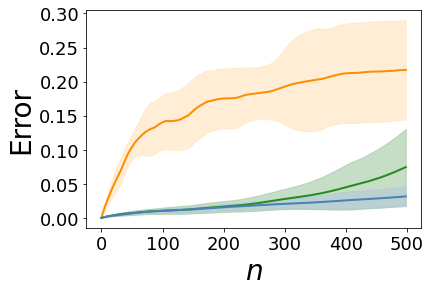

In [115]:
t_axis = np.arange(0, traj_len_test - 1, 1)

plt.plot(mean_rbf, label="M4-RBF", color="darkorange", linewidth=2)
plt.fill_between(t_axis, mean_minus_rbf, mean_plus_rbf, color="navajowhite", alpha=0.5)

plt.plot(mean_dl_polyK, label="M4-NN", color="forestgreen", linewidth=2)
plt.fill_between(t_axis, mean_minus_dl_polyK, mean_plus_dl_polyK, color="darkseagreen", alpha=0.5)


plt.plot(mean_pk, label="Ours", color="steelblue", linewidth=2)
plt.fill_between(t_axis, mean_minus_pk, mean_plus_pk, color="lightsteelblue", alpha=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
# plt.legend(fontsize=14, loc=(1.05,1.01))

plt.savefig(os.path.join(figures_path, 'high_u_fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'high_u_fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


In [110]:
dict_error = {"pk": ratio_pk_list, "rbf": ratio_rbf_list, "dl": ratio_dl_polyK_list}

In [111]:
np.save(os.path.join('high_u_error_dict.npy'), dict_error)

/home/guoyue/Learning-Parametric-Koopman-Decompositions/src/koopmanlib/functions.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


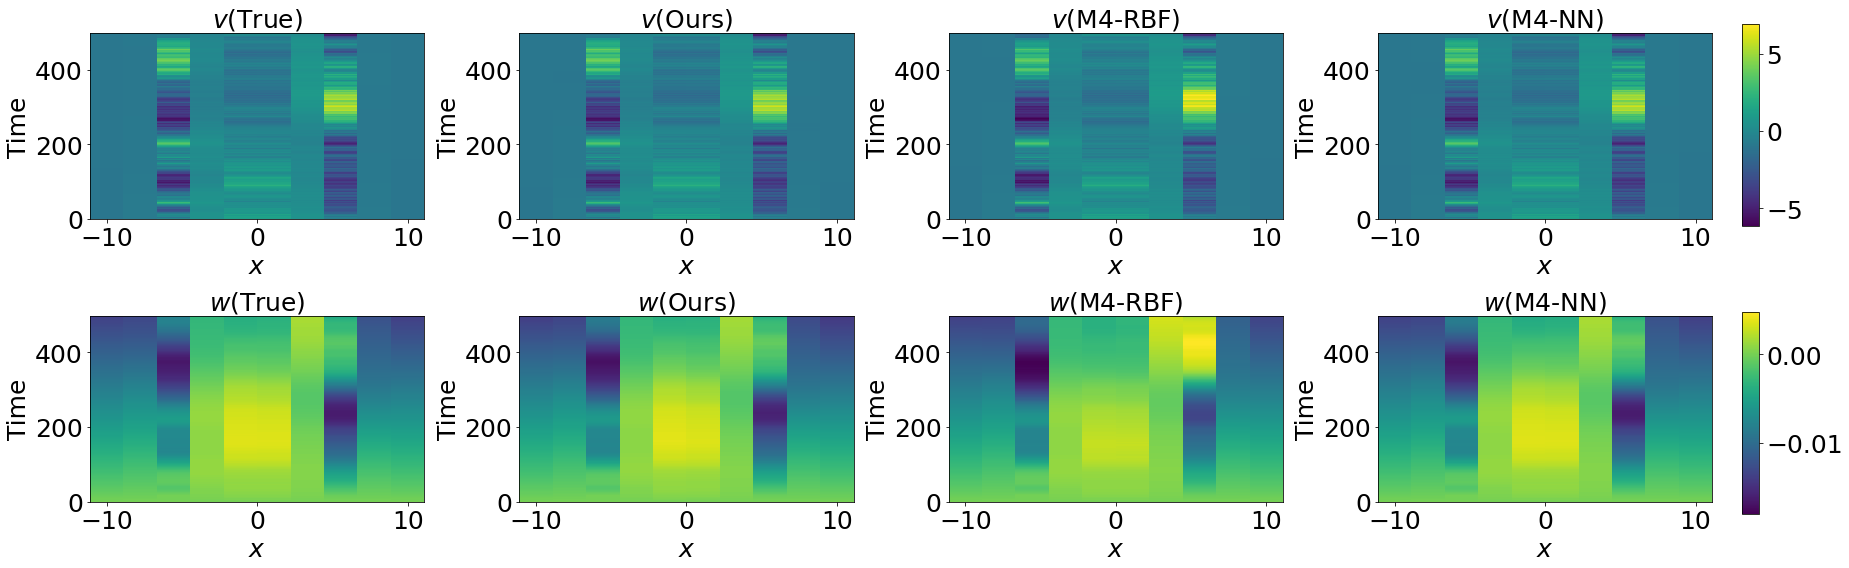

In [112]:
data_list = [z_curr_ori, data_pred_pk_recover, data_pred_rbf_recover, data_pred_dl_polyK_recover]
data_label_list = ['True', 'Ours','M4-RBF', 'M4-NN' ]
plot_pde_comparison(x_axis,
                    y_axis,
                    data_list,
                    data_label_list, 
                    Nx, 
                    figsize=(24,8),
                    cbar_ax = ([1.01, 0.60, 0.01, 0.35], [1.01, 0.10, 0.01, 0.35]),
                    fontsize=25)


# plt.savefig(os.path.join(figures_path, 'traj_high_u_fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'traj_high_u_fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


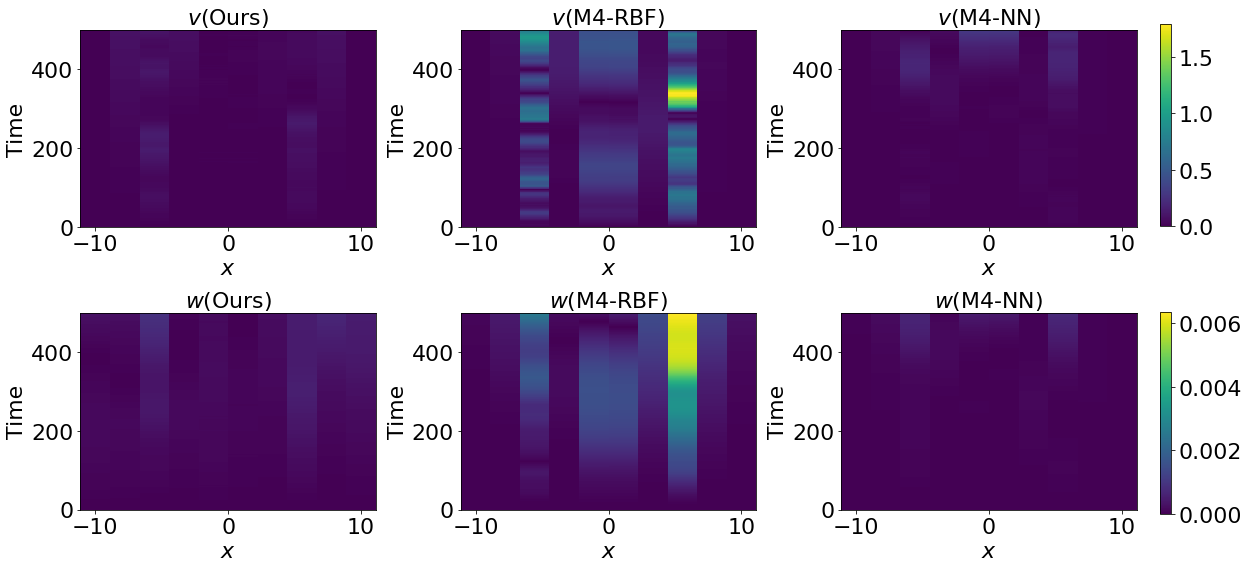

In [113]:
# data_diff_list = [data_list[1]-data_list[0], data_list[2]-data_list[0], data_list[3]-data_list[0]]

data_diff_list = [np.abs(data_list[1]-data_list[0]), 
                  np.abs(data_list[2]-data_list[0]),
                  np.abs(data_list[3]-data_list[0])]

data_diff_label_list = data_label_list[1:]

plot_pde_comparison(x_axis,
                    y_axis,
                    data_diff_list, 
                    data_diff_label_list, 
                    Nx,
                    figsize=(16,8),
                    cbar_ax = ([1.01, 0.60, 0.01, 0.35], [1.01, 0.10, 0.01, 0.35]))

plt.savefig(os.path.join(figures_path, 'diff_high_u_traj_fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'diff_high_u_traj_fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


In [114]:
data_diff_list

[array([[0.00000000e+00, 1.11022302e-16, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.41394021e-04, 6.84244916e-05, 4.90609940e-04, ...,
         1.14519230e-06, 7.27054711e-08, 6.06286236e-07],
        [2.56231108e-04, 1.48116870e-04, 1.51188408e-03, ...,
         2.26231491e-06, 3.00563237e-07, 4.20902251e-07],
        ...,
        [4.71396725e-03, 7.97395869e-02, 9.54812569e-02, ...,
         4.93484069e-04, 6.84237106e-04, 5.04421346e-04],
        [4.92667507e-03, 8.00082416e-02, 9.74208162e-02, ...,
         4.94485019e-04, 6.84963859e-04, 5.06327902e-04],
        [4.91855670e-03, 8.01396416e-02, 9.97099016e-02, ...,
         4.95118442e-04, 6.85106227e-04, 5.05486167e-04]]),
 array([[0.00000000e+00, 1.11022302e-16, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.15684970e-06, 1.60777343e-06, 2.84795644e-03, ...,
         7.46492088e-08, 9.97715561e-11, 6.15875061e-11],
        [7.14280267e-06, 